In [118]:
import pandas as pd
import seaborn as sns
import NegativeClassOptimization.config as config
import matplotlib.pyplot as plt
import glob
import numpy as np
from scipy.stats import pearsonr
from NegativeClassOptimization import visualisations, utils
from pathlib import Path


In [180]:
pellets = {'color_blind_light':['#a2c8ec','#cfcfcf', '#ffbc79'], 
'color_blind_dark':['#5CA7E5','#ababab', '#ff7700'],
'r_like':['#94669E', '#F2D81D', '#00817A'],
'chat_gpt': ['#FFC300', '#FF5733', '#00A6ED'],
'antigens': ['#008080','#FFA07A','#000080','#FFD700','#228B22','#FF69B4','#800080','#FF6347','#00FF00','#FF1493']}

cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}


ag_order = [
        "1FBI",
        "3VRL",
        "2YPV",
        "5E94",
        "1WEJ",
        "1OB1",
        "1NSN",
        "1H0D",
        "3RAJ",
        "1ADQ",
    ]
task_clean_order = ['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak']

folder_2_task = {'1v9': 'vs 9', 'high_vs_95low': 'vs Non-binder', 'high_vs_looser': 'vs Weak', '1v1': 'vs 1'}
task_2_folder = {'vs 9':'1v9', 'vs Non-binder':'high_vs_95low', 'vs Weak': 'high_vs_looser', 'vs 1':'1v1'}

In [193]:
perf_df = pd.read_csv(config.DATA_BASE_PATH/'openset_performance.tsv', sep='\t')
perf_df[['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id']] = perf_df.task_1.str.split('__', expand=True)
perf_df[['test_task', 'test_ag', 'test_neg', 'test_seed_id', 'test_split_id']] = perf_df.task_2.str.split('__', expand=True)
perf_df.drop(['task_1', 'task_2'], inplace=True, axis=1)
task_rename = {'ONE_VS_NINE': 'vs 9', 'HIGH_VS_95LOW': 'vs Non-binder', 'HIGH_VS_LOOSER': 'vs Weak', 'ONE_VS_ONE': 'vs 1'}
perf_df['train_task'] = perf_df['train_task'].apply(lambda x: task_rename[x])
perf_df['test_task'] = perf_df['test_task'].apply(lambda x: task_rename[x])


In [194]:
df_1vs1 = pd.read_csv(config.DATA_BASE_PATH/'1vs1_perf.tsv', sep='\t', index_col=0)

df_1vs1_open = pd.read_csv(config.DATA_BASE_PATH/'1vs1_perf_open.tsv', sep='\t', index_col=0)
df_1vs1_open['test_neg'] = 'auto'

perf_on_vs1 = pd.read_csv(config.DATA_BASE_PATH/'perf_on_vs1.tsv', sep='\t', index_col=0)
perf_on_vs1.rename(columns={'pos_ag':'train_ag', 'neg_ag':'train_neg', 'pos_ag.1':'test_ag', 'neg_ag.1':'test_neg','prec':'precision'}, inplace=True)
perf_on_vs1.drop(['seed_id.1', 'split_id.1'], inplace=True, axis=1)
perf_on_vs1['train_neg'] = 'auto'
perf_on_vs1['train_task'] = perf_on_vs1['train_task'].apply(lambda x: folder_2_task[x])
#perf_df.drop(columns=['test_split_id', 'test_seed_id'], inplace=True, axis=1)
#df_1vs1_open.drop(columns=['test_split_id', 'test_seed_id'], inplace=True, axis=1)
df_1vs1_open['test_task'] = df_1vs1_open['test_task'].apply(lambda x: folder_2_task[x])
perf_df = pd.concat([perf_df,df_1vs1, df_1vs1_open, perf_on_vs1], axis=0)

perf_open_df = perf_df[perf_df['train_task'] != perf_df['test_task']] 
df_closed = perf_df[perf_df['train_task'] == perf_df['test_task']]

In [8]:
df_closed_wo1 = df_closed[df_closed['test_task'] != 'vs 1']

In [9]:
tasks = perf_df['train_task'].unique()

In [10]:
perf_wo_1 = perf_df[(perf_df['test_task'] != 'vs 1') & (perf_df['train_task'] != 'vs 1')]

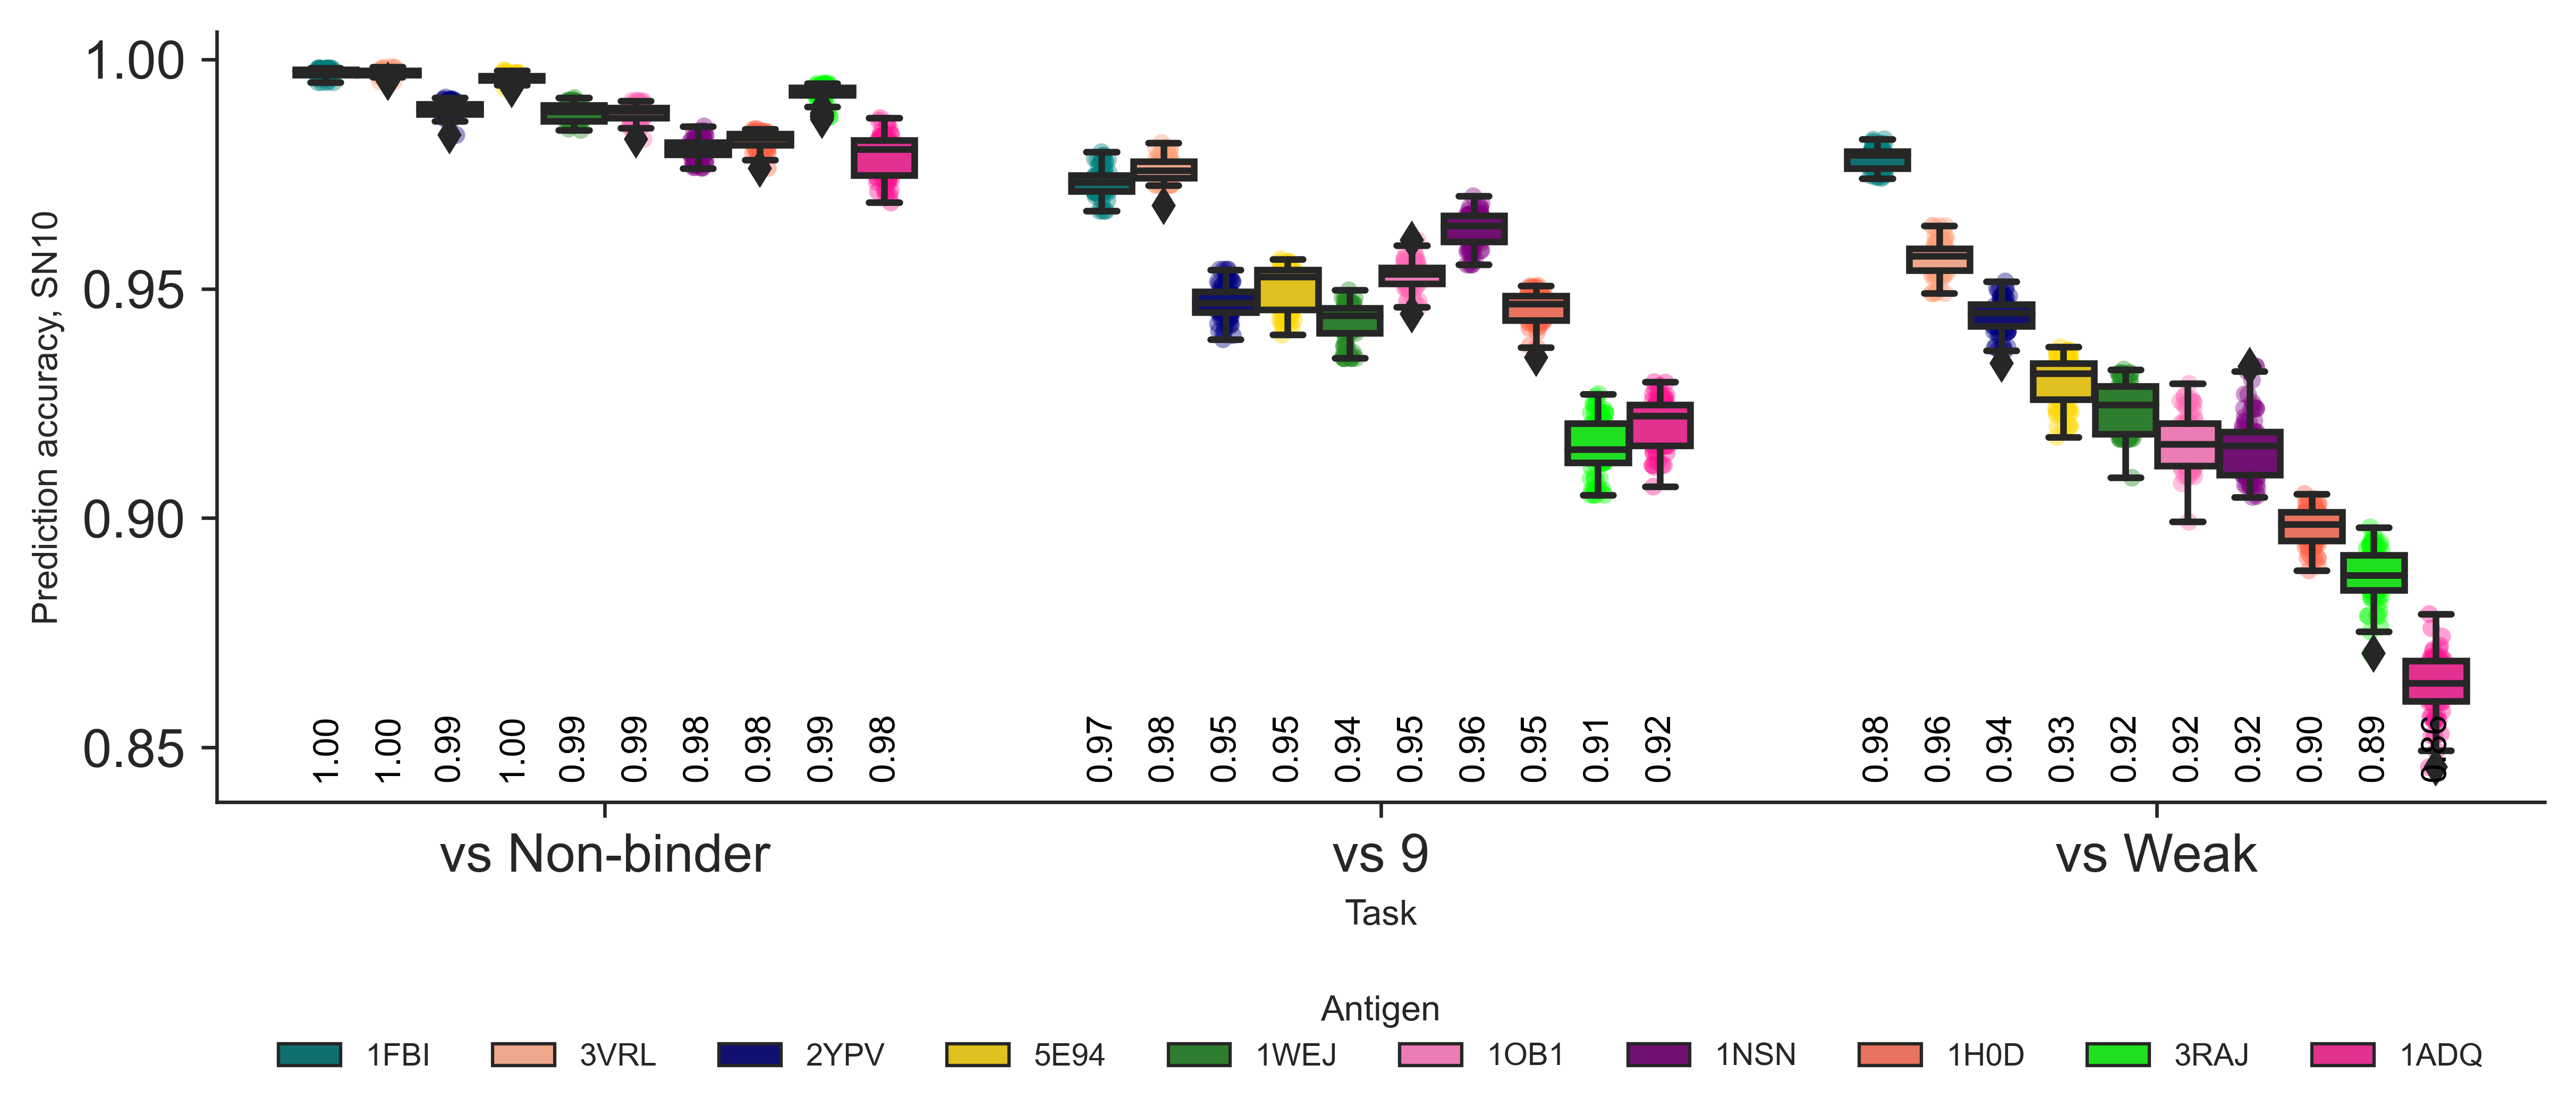

In [11]:
plt.rcParams['svg.fonttype'] = 'none'
#yticks = np.arange(0.85, 1.0, 0.05)
plt.rcParams['svg.fonttype'] = 'none'
yaxis_title = "Prediction accuracy, SN10"
ag_order = [
        "1FBI",
        "3VRL",
        "2YPV",
        "5E94",
        "1WEJ",
        "1OB1",
        "1NSN",
        "1H0D",
        "3RAJ",
        "1ADQ",
    ]
#task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
task_order = ['vs Non-binder', 'vs 9', 'vs Weak']#['vs Non-binder','vs 1', 'vs 9', 'vs Loose']

sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)

stripplot = sns.stripplot(
    x="train_task",
    y="acc",
    hue="train_ag",
    data=df_closed_wo1 ,
    ax=ax,
    order=task_order,
    hue_order=ag_order,
    palette=pellets['antigens'],
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
    zorder=1 
)

# Transparent boxplot
boxplot = sns.boxplot(
    x="train_task",
    y="acc",
    hue="train_ag",
    data=df_closed_wo1 ,
    ax=ax,
    order=task_order,
    hue_order=ag_order,
    palette=pellets['antigens'],
    boxprops=dict(alpha=1),
    zorder=2
    )

for artist in stripplot.collections:
    artist.set_zorder(1)

# Set the z-order of the boxplot patches to be higher than that of the stripplot
for artist in boxplot.patches:
    artist.set_zorder(2)

#add_median_labels(ax, y_level=0.85, fontsize=8)
visualisations.add_median_labels(ax, y_level=0.85, fontsize=8)


ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Antigen",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

ax.set_xlabel("Task", fontsize=8)
ax.set_ylabel(yaxis_title, fontsize=8)
yticks = np.arange(0.85, 1.0, 0.05)
ax.set_yticks(yticks)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#fig.savefig('./figures/by_task_closed.svg')

In [13]:
EXECUTE = False
if EXECUTE:
    jsds = []
    for task in tasks:
        datasets_paths = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{task_2_folder[task]}/seed_*/split_*/*/*_test_dataset.tsv') #why we did on test? see what happens on train.
        for path in datasets_paths:
            df = pd.read_csv(path, sep='\t')
            slides_pos = df[df['y'] == 1]['Slide'].to_list()
            slides_neg = df[df['y'] == 0]['Slide'].to_list()
            jsd = utils.jensen_shannon_divergence_slides(slides_neg, slides_pos)
            train_task = task
            seed = path.split('/')[4].split('_')[1]
            split = path.split('/')[5].split('_')[1]
            if task == 'vs 1':
                train_ag = path.split('/')[6].split('__')[0]
                train_neg = path.split('/')[6].split('__')[2]
                seed = int(path.split('/')[4].split('_')[1])
                split = int(path.split('/')[5].split('_')[1])
            else:
                train_ag = path.split('/')[6].split('__')[0].split('_')[0]
                train_neg = 'auto'
            try:
                acc = df_closed[(df_closed['train_task'] == train_task) & (df_closed['train_ag'] == train_ag) &\
                        (df_closed['train_neg'] == train_neg) & (df_closed['seed_id'] == seed) & (df_closed['split_id'] == split)]['acc'].values[0]
                jsds.append([train_task, jsd, acc, train_ag, train_neg, seed, split])
            except:
                print(path)
    df_jsds = pd.DataFrame(jsds, columns=['train_task', 'jsd', 'acc', 'train_ag', 'train_neg', 'seed', 'split'])
    df_jsds.to_csv('../jsd_section1.csv')

In [17]:
df_jsds = pd.read_csv('../jsd_section1.csv')
df_jsds.drop('Unnamed: 0', axis=1, inplace=True)

In [18]:
df_jsds_means = df_jsds.groupby(['train_ag','train_neg', 'train_task']).mean().reset_index()


In [19]:
df_jsds_means

train_ag train_neg     train_task       jsd       acc  seed  split
0       1ADQ      1FBI           vs 1  3.876352  0.981210   0.6   22.0
1       1ADQ      1H0D           vs 1  3.209635  0.976370   0.6   22.0
2       1ADQ      1NSN           vs 1  3.478722  0.976320   0.6   22.0
3       1ADQ      1OB1           vs 1  3.243824  0.978380   0.6   22.0
4       1ADQ      1WEJ           vs 1  3.581892  0.972260   0.6   22.0
..       ...       ...            ...       ...       ...   ...    ...
115     5E94      3RAJ           vs 1  2.916260  0.945860   0.6   22.0
116     5E94      3VRL           vs 1  4.926536  0.982400   0.6   22.0
117     5E94      auto           vs 9  2.872243  0.943452   0.6   22.0
118     5E94      auto  vs Non-binder  3.530181  0.995350   0.6   22.0
119     5E94      auto        vs Weak  1.642270  0.922180   0.6   22.0

[120 rows x 7 columns]

In [20]:
df_jsds_means['dupl_filter'] = df_jsds_means.apply(lambda row: str('_'.join(sorted([row['train_ag'],row['train_neg']])) + '_' + row['train_task']), axis=1)

In [21]:
df_jsds_means_wo_dupl = df_jsds_means.drop_duplicates('dupl_filter')

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_72653/2556823295.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


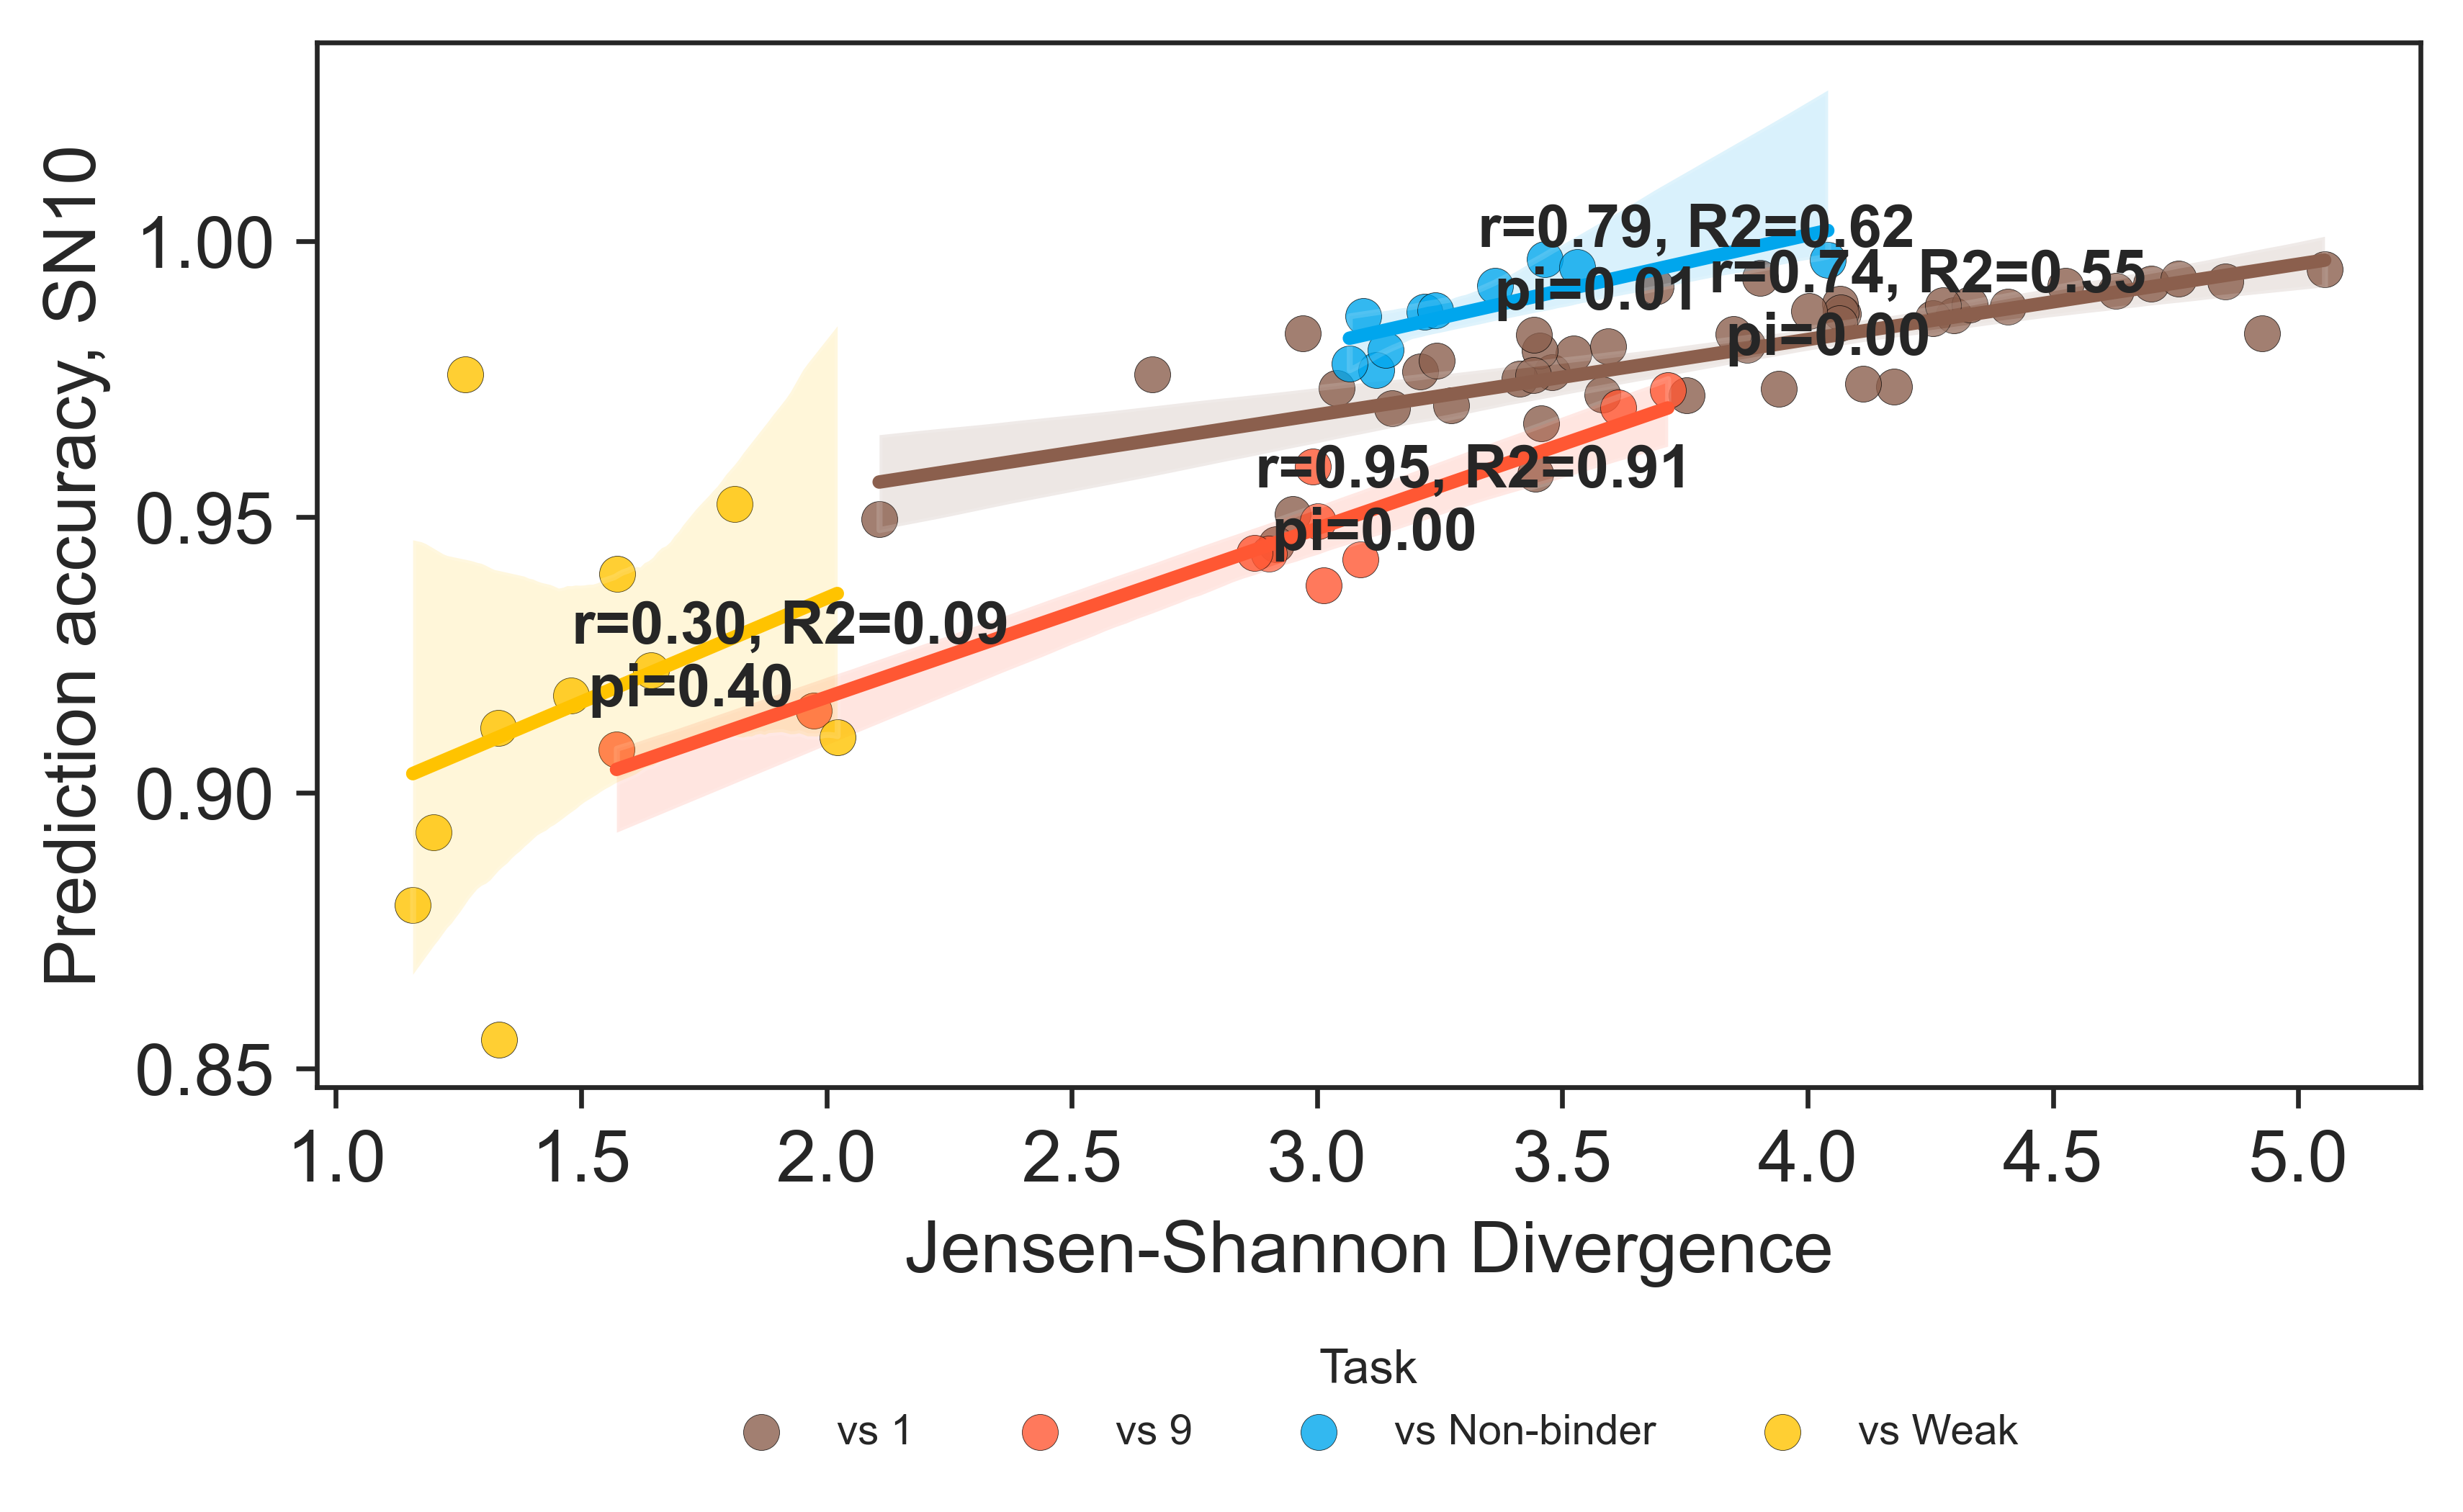

In [23]:
sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

# Line plot in seaborn with R2 regression
for task, df_g in df_jsds_means_wo_dupl.groupby("train_task"):
    sns.regplot(
        x="jsd",
        y="acc",
        data=df_g,
        scatter=True,
        ax=ax,
        label=task,
        color=cmap[task],
        scatter_kws={'edgecolor': 'black', 'linewidth': 0.1} 
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["jsd"], df_g["acc"])
    # Add text with r and R2 at centroid
    x = df_g["jsd"].mean()
    y = df_g["acc"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f} \n pi={pval:.2f}" , fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

#get_regression_correlatrion("jsd", "acc", df_jsds_wo_dupl, ax, "Task")

ax.set_xlabel("Jensen-Shannon Divergence", fontsize=FONT_SIZE)
ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)
yticks = np.arange(0.85, 1.0, 0.05)
ax.set_yticks(yticks)


# put legend to the bottom
fig.show()
#fig.savefig('./figures/closed_jsd_vs_acc_avg.svg')

In [75]:
df_jsds_means_wo_dupl.query("train_ag == '5E94'")

train_ag train_neg     train_task       jsd       acc  seed  split  \
117     5E94      auto           vs 9  2.872243  0.943452   0.6   22.0   
118     5E94      auto  vs Non-binder  3.530181  0.995350   0.6   22.0   
119     5E94      auto        vs Weak  1.642270  0.922180   0.6   22.0   

                 dupl_filter  
117           5E94_auto_vs 9  
118  5E94_auto_vs Non-binder  
119        5E94_auto_vs Weak

In [83]:
df_jsds_means.columns

Index(['train_ag', 'train_neg', 'train_task', 'jsd', 'acc', 'seed', 'split',
       'dupl_filter'],
      dtype='object')

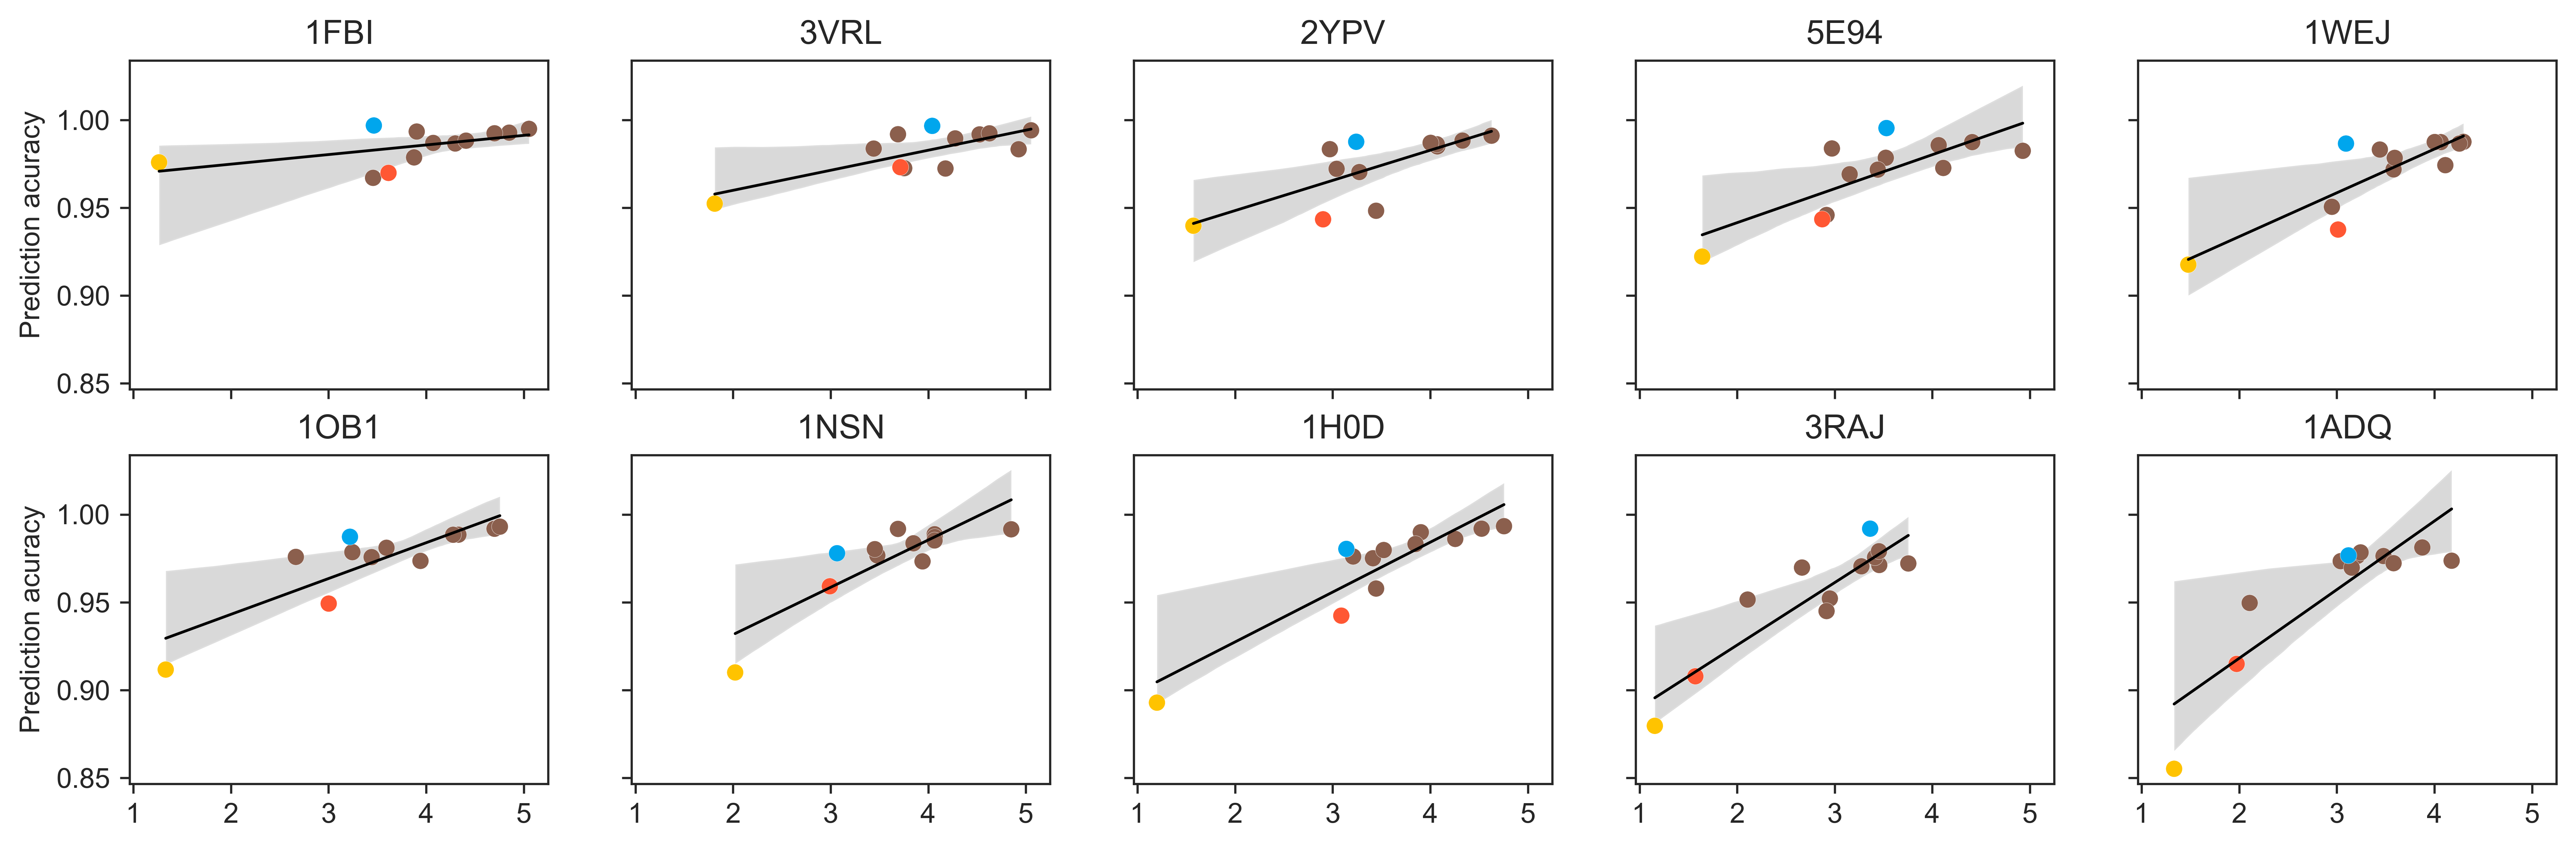

In [115]:
#open performance
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')

fig, ax = plt.subplots(2,5,figsize= (5 * 3.14, 1.5 * 3.14), sharey=True, sharex=True, dpi=600)
# set font size
for i, ag in enumerate(ag_order):
    r = i //5
    c = i % 5
    df = df_jsds_means.query('train_ag == @ag')
    ax_=ax[r,c]

    sns.regplot(
            x="jsd",
            y="acc",
            data=df,
            scatter=False,
            ax=ax_,
            color='black',
            line_kws={'linewidth':1})


    sns.scatterplot(
            x="jsd",
            y="acc",
            data=df,
            ax=ax_,
            palette = cmap,
            edgecolors = "black",
            linewidth = 0.1,
            hue='train_task',
            legend=False
            #scatter_kws={'edgecolor': 'black', 'linewidth': 0.1} 
            )
    
    ax_.set_title(ag, fontsize=12)
    if c!=0:
        ax_.set_ylabel('')
    else:
        ax_.set_ylabel('Prediction acuracy')
    #remove xlabel
    ax_.set_xlabel('')

#save
#fig.savefig('./figures/delta_jsd_vs_delta_acc_by_ag.svg')




'fig.legend(\n    handles,\n    labels,\n    loc="upper center",\n    ncol=5,\n    fontsize=8,\n    frameon=False,\n    # title="Model trained on",\n    title_fontsize=8,\n)'

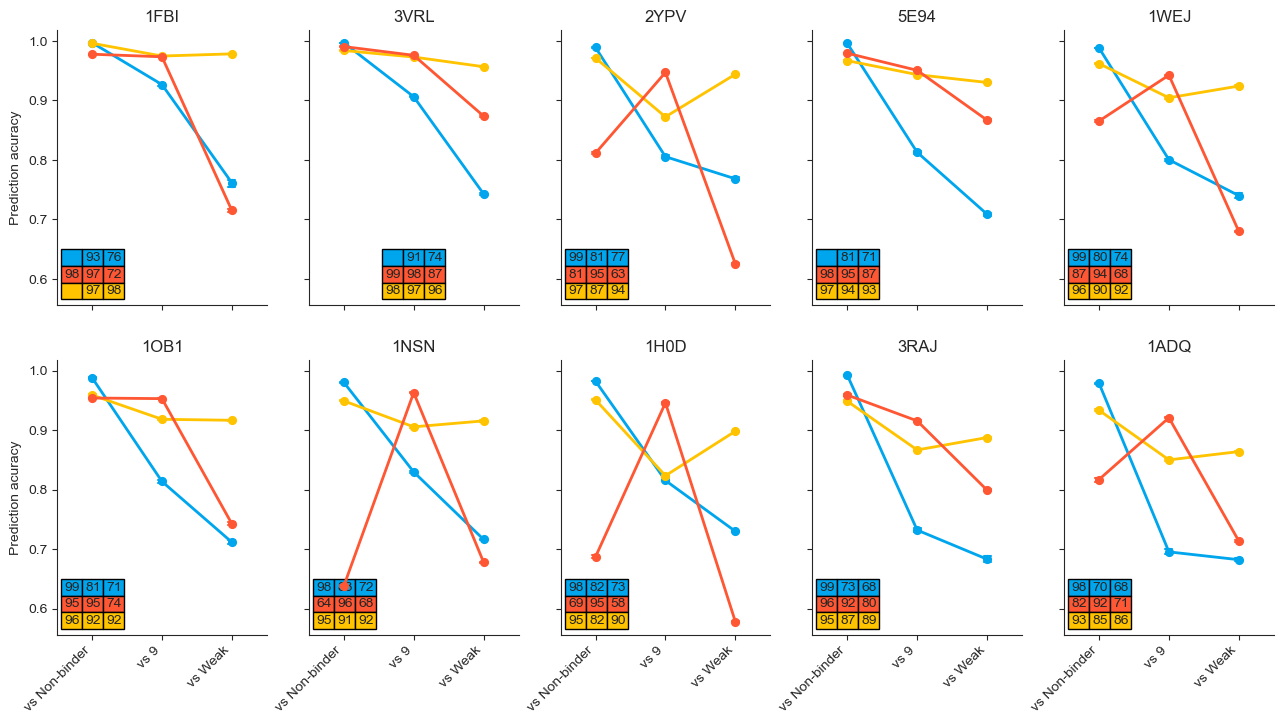

In [25]:
#open performance
perf_wo_1 = perf_df[(perf_df['test_task'] != 'vs 1') & (perf_df['train_task'] != 'vs 1')]
fig, ax = plt.subplots(2,5,figsize= (5 * 3.14, 2.5* 3.14), sharey=True, sharex=True)
sns.set_style('ticks')
# set font size
for i, ag in enumerate(ag_order):
    r = i //5
    c = i % 5
    sns.pointplot(perf_wo_1[perf_wo_1['train_ag'] == ag], x='test_task', y='acc', order = ['vs Non-binder', 'vs 9', 'vs Weak'],  \
        hue='train_task',  errorbar= ('ci', 95),  palette = cmap, ax=ax[r,c], scale=0.75, capsize=.1, errwidth=1.5)
    ax[r,c].legend().set_visible(False)
    ax[r,c].set_title(ag, fontsize=12)
    # set_horizontalalignment 

    if c!=0:
       ax[r,c].set_ylabel('')
    else:
        ax[r,c].set_ylabel('Prediction acuracy')
    #remove xlabel
    ax[r,c].set_xlabel('')

    #rotate xticks
    ax[r,c].set_xticklabels(ax[r,c].get_xticklabels(), rotation=45) 
    for tick in ax[r,c].get_xticklabels():
        tick.set_horizontalalignment("right")

    #set font size
    #ax[r,c].tick_params(axis='both', which='major', labelsize=8)
    #REMOVE upper and right spines
    ax[r,c].spines['right'].set_visible(False)
    ax[r,c].spines['top'].set_visible(False)

     # Tables inside the plot
    if r == 0 and c == 1:
        loc = "lower center"
    else:
        loc = "lower left"
    table_values = (perf_wo_1[perf_wo_1['train_ag'] == ag].groupby(["train_task", "test_task"])["acc"].mean()\
    .reset_index().pivot(index="train_task", columns="test_task", values="acc")\
    .reindex(['vs Non-binder', 'vs 9', 'vs Weak'], axis=1).reindex(['vs Non-binder', 'vs 9', 'vs Weak'], axis=0)\
    .values * 100).round().astype('int')
    table_values = np.where(table_values == 100, "", table_values)
    ax[r,c].table(
        cellText=table_values,
        loc=loc,
        colWidths=[0.1, 0.1, 0.1],
        cellColours=np.array([['#00A6ED', '#FF5733', '#FFC300'] for _ in range(3)]).transpose(),
    )
    #line width 
    



# set common x axis label
#fig.text(0.5, 0, 'Test task', ha='center', va='center')

#one legend for all subplots
handles, labels = ax[0,0].get_legend_handles_labels()
"""fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=5,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    title_fontsize=8,
)"""
#fig.savefig('./figures/openset_performance.svg')

#TODO: change x-labels, y-label, make y-tick labels bigger, add lehend with handles 


### Supfig 3d

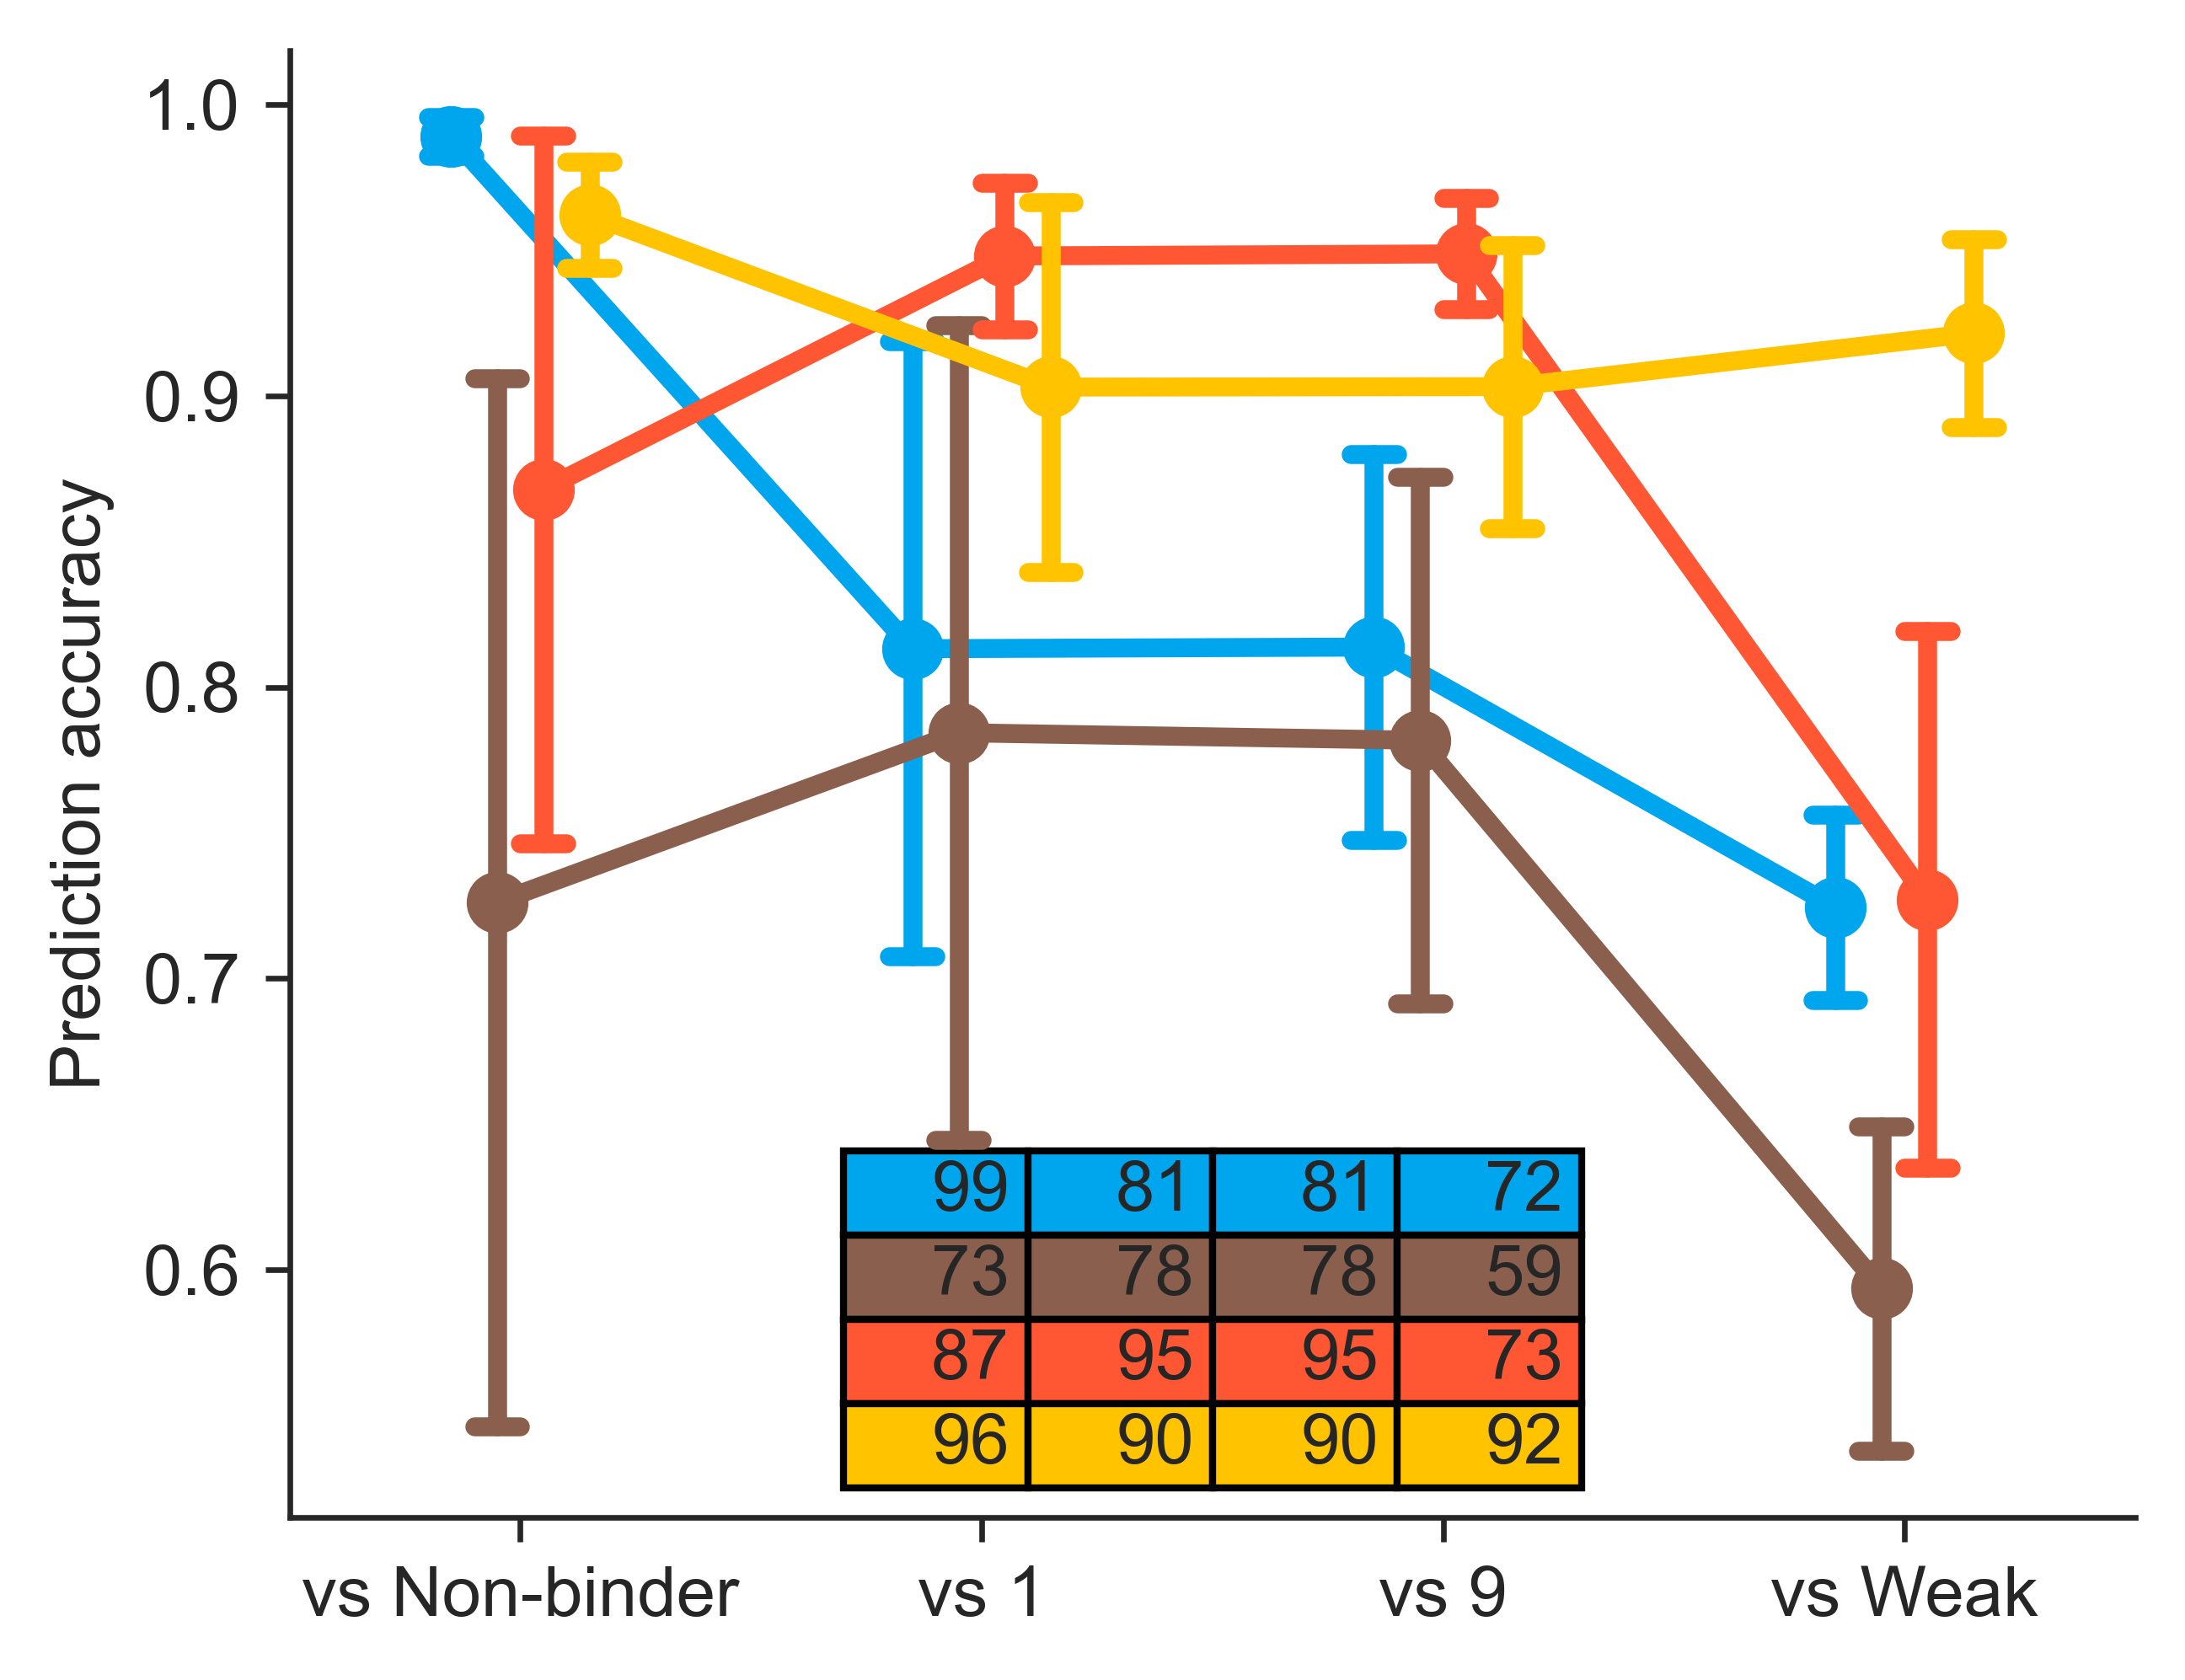

In [189]:
fig, ax = plt.subplots(figsize=(1.5* 3.14, 1.2 * 3.14), dpi=600)
sns.set_style("white")
sns.set_style('ticks')
sns.pointplot(
    perf_df,
    y="acc",
    x="test_task",
    errorbar="sd",
    order=task_clean_order,
    hue="train_task",
    hue_order = task_clean_order,
    palette= cmap,
    # Spread out the points a bit in horizontal
    dodge=0.3,
    ax=ax,
    capsize=0.1,
    estimator='mean'
)

# Add legend horizontally on top of plot area, outside plot area
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    # title_fontsize=8,
)

ax.set_xlabel(None)
ax.set_ylabel("Prediction accuracy")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend().set_visible(False)

#table
table_values = (perf_df.groupby(["train_task", "test_task"])["acc"].mean()\
    .reset_index().pivot(index="train_task", columns="test_task", values="acc")
    .loc[task_clean_order, task_clean_order]\
    .values * 100).round().astype('int')
    #table_values = np.where(table_values == 100, "", table_values)
ax.table(
    cellText=table_values,
    loc='lower center',
    colWidths=[0.1]*4,
    cellColours=np.array([['#00A6ED', '#8B5F4D', '#FF5733', '#FFC300'] for _ in range(4)]).transpose(),
    )

#fig.savefig('./figures/joined_perf_by_task.svg')

### SupFigure 5

In [195]:
df_open_full = pd.concat([pd.read_csv(config.DATA_BASE_PATH/'1vs1_open.csv'), perf_open_df[['acc', 'recall', 'precision', 'f1', 'train_task', 'train_ag',\
       'train_neg', 'seed_id', 'split_id', 'test_task', 'test_ag', 'test_neg','test_seed_id', 'test_split_id']]],axis = 0)

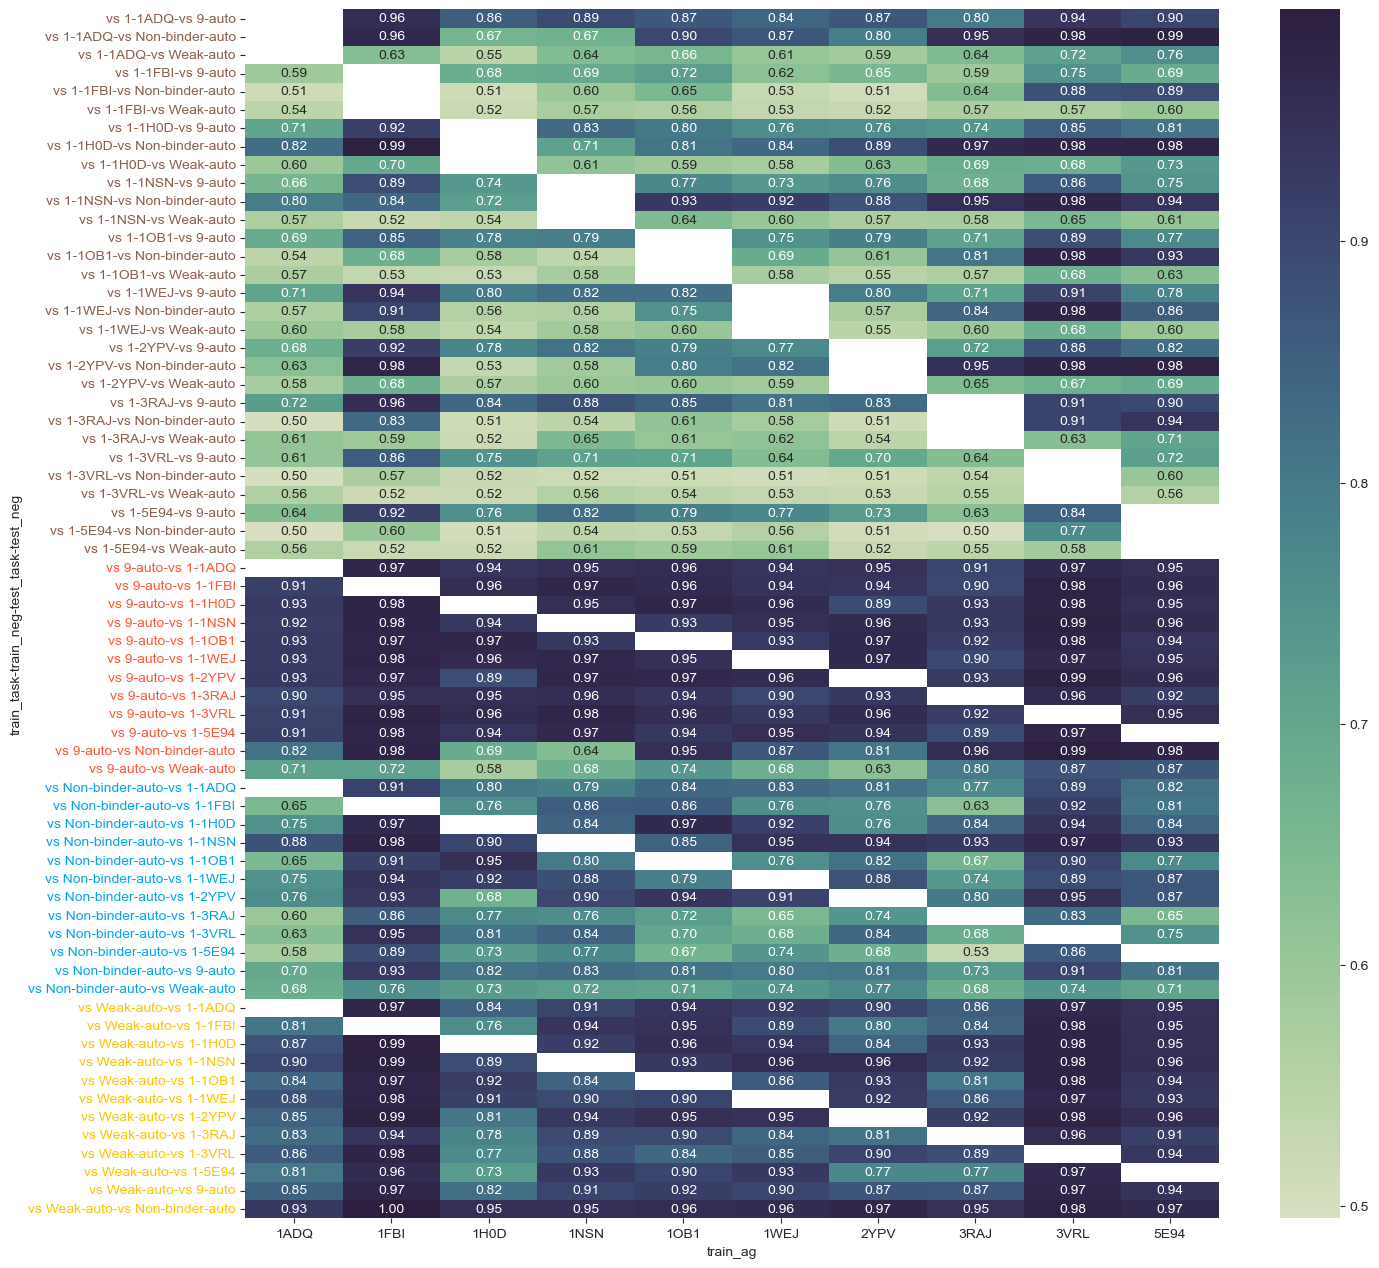

In [30]:
#remove  where train and test task "vs 1"
custom_pel = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
df_open_wo1vs1 = df_open_full[df_open_full['train_task'] != df_open_full['test_task']]
fig, ax = plt.subplots(1,1,figsize= (5 * 3.14, 5* 3.14), sharey=True, sharex=True)
sns.heatmap(df_open_wo1vs1.pivot_table(index=['train_task','train_neg','test_task','test_neg'], columns=['train_ag'], values='acc'), cmap=custom_pel, ax=ax, annot=True, fmt=".2f")
#color rowlabels by 'train_task'
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
for tick in ax.get_yticklabels():
    #get label name
    label = tick.get_text()
    label = label.split('-')[0]
    #set color
    if label == 'vs Non':
        label = 'vs Non-binder'
    tick.set_color(cmap[label])

#fig.savefig('./figures/openset_performance_wo1vs1.svg')


### JSD open performace

In [31]:
jsd_dict  = dict()
for i in range(df_jsds.shape[0]):
    row = df_jsds.iloc[i]
    jsd_dict[row['train_task'], row['train_ag'],row['train_neg'],int(row['seed']), int(row['split'])] = row['jsd']

closed_acc_dict = dict()
for i in range(df_closed.shape[0]):
    row = df_closed.iloc[i]
    closed_acc_dict[row['train_task'], row['train_ag'],row['train_neg'],int(row['seed_id']), int(row['split_id'])] = row['acc']

perf_open_df['train_jsd'] = perf_open_df.apply(lambda row: jsd_dict[row['train_task'], row['train_ag'],row['train_neg'],int(row['seed_id']), int(row['split_id'])], axis=1)
perf_open_df['test_jsd'] = perf_open_df.apply(lambda row: jsd_dict[row['test_task'], row['test_ag'],row['test_neg'],int(row['seed_id']), int(row['split_id'])], axis=1)
perf_open_df['closed_acc'] = perf_open_df.apply(lambda row: closed_acc_dict[row['train_task'], row['train_ag'],row['train_neg'],int(row['seed_id']), int(row['split_id'])], axis=1)

perf_open_df['delta_jsd'] =  perf_open_df['train_jsd'] - perf_open_df['test_jsd']
perf_open_df['delta_acc'] =  perf_open_df['closed_acc'] - perf_open_df['acc']
perf_open_df.reset_index(inplace=True, drop=True)
perf_open_df['delta_jsd_norm'] = perf_open_df['delta_jsd']/perf_open_df['train_jsd']
perf_open_df['delta_acc_norm'] = perf_open_df['delta_acc']/perf_open_df['closed_acc']

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_72653/806737188.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_open_df['train_jsd'] = perf_open_df.apply(lambda row: jsd_dict[row['train_task'], row['train_ag'],row['train_neg'],int(row['seed_id']), int(row['split_id'])], axis=1)
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_72653/806737188.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_open_df['test_jsd'] = perf_open_df.apply(lambda row: jsd_dict[row['test_task'],

In [32]:
# I need to write down how I filter sequences
perf_open_df['dupl_filter'] = perf_open_df.apply(lambda row: '_'.join(row[['train_ag','train_neg']]) + '_' + '_'.join(row[['train_task','test_task']].values) + '_' + '_'.join(sorted(row[['test_ag', 'test_neg']])), axis=1)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_72653/928188024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_open_df['dupl_filter'] = perf_open_df.apply(lambda row: '_'.join(row[['train_ag','train_neg']]) + '_' + '_'.join(row[['train_task','test_task']].values) + '_' + '_'.join(sorted(row[['test_ag', 'test_neg']])), axis=1)


In [33]:
perf_open_df_means = perf_open_df.groupby(['train_ag','train_neg','train_task','test_task','test_ag', 'test_neg']).mean().reset_index()

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_72653/2184547724.py:64: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


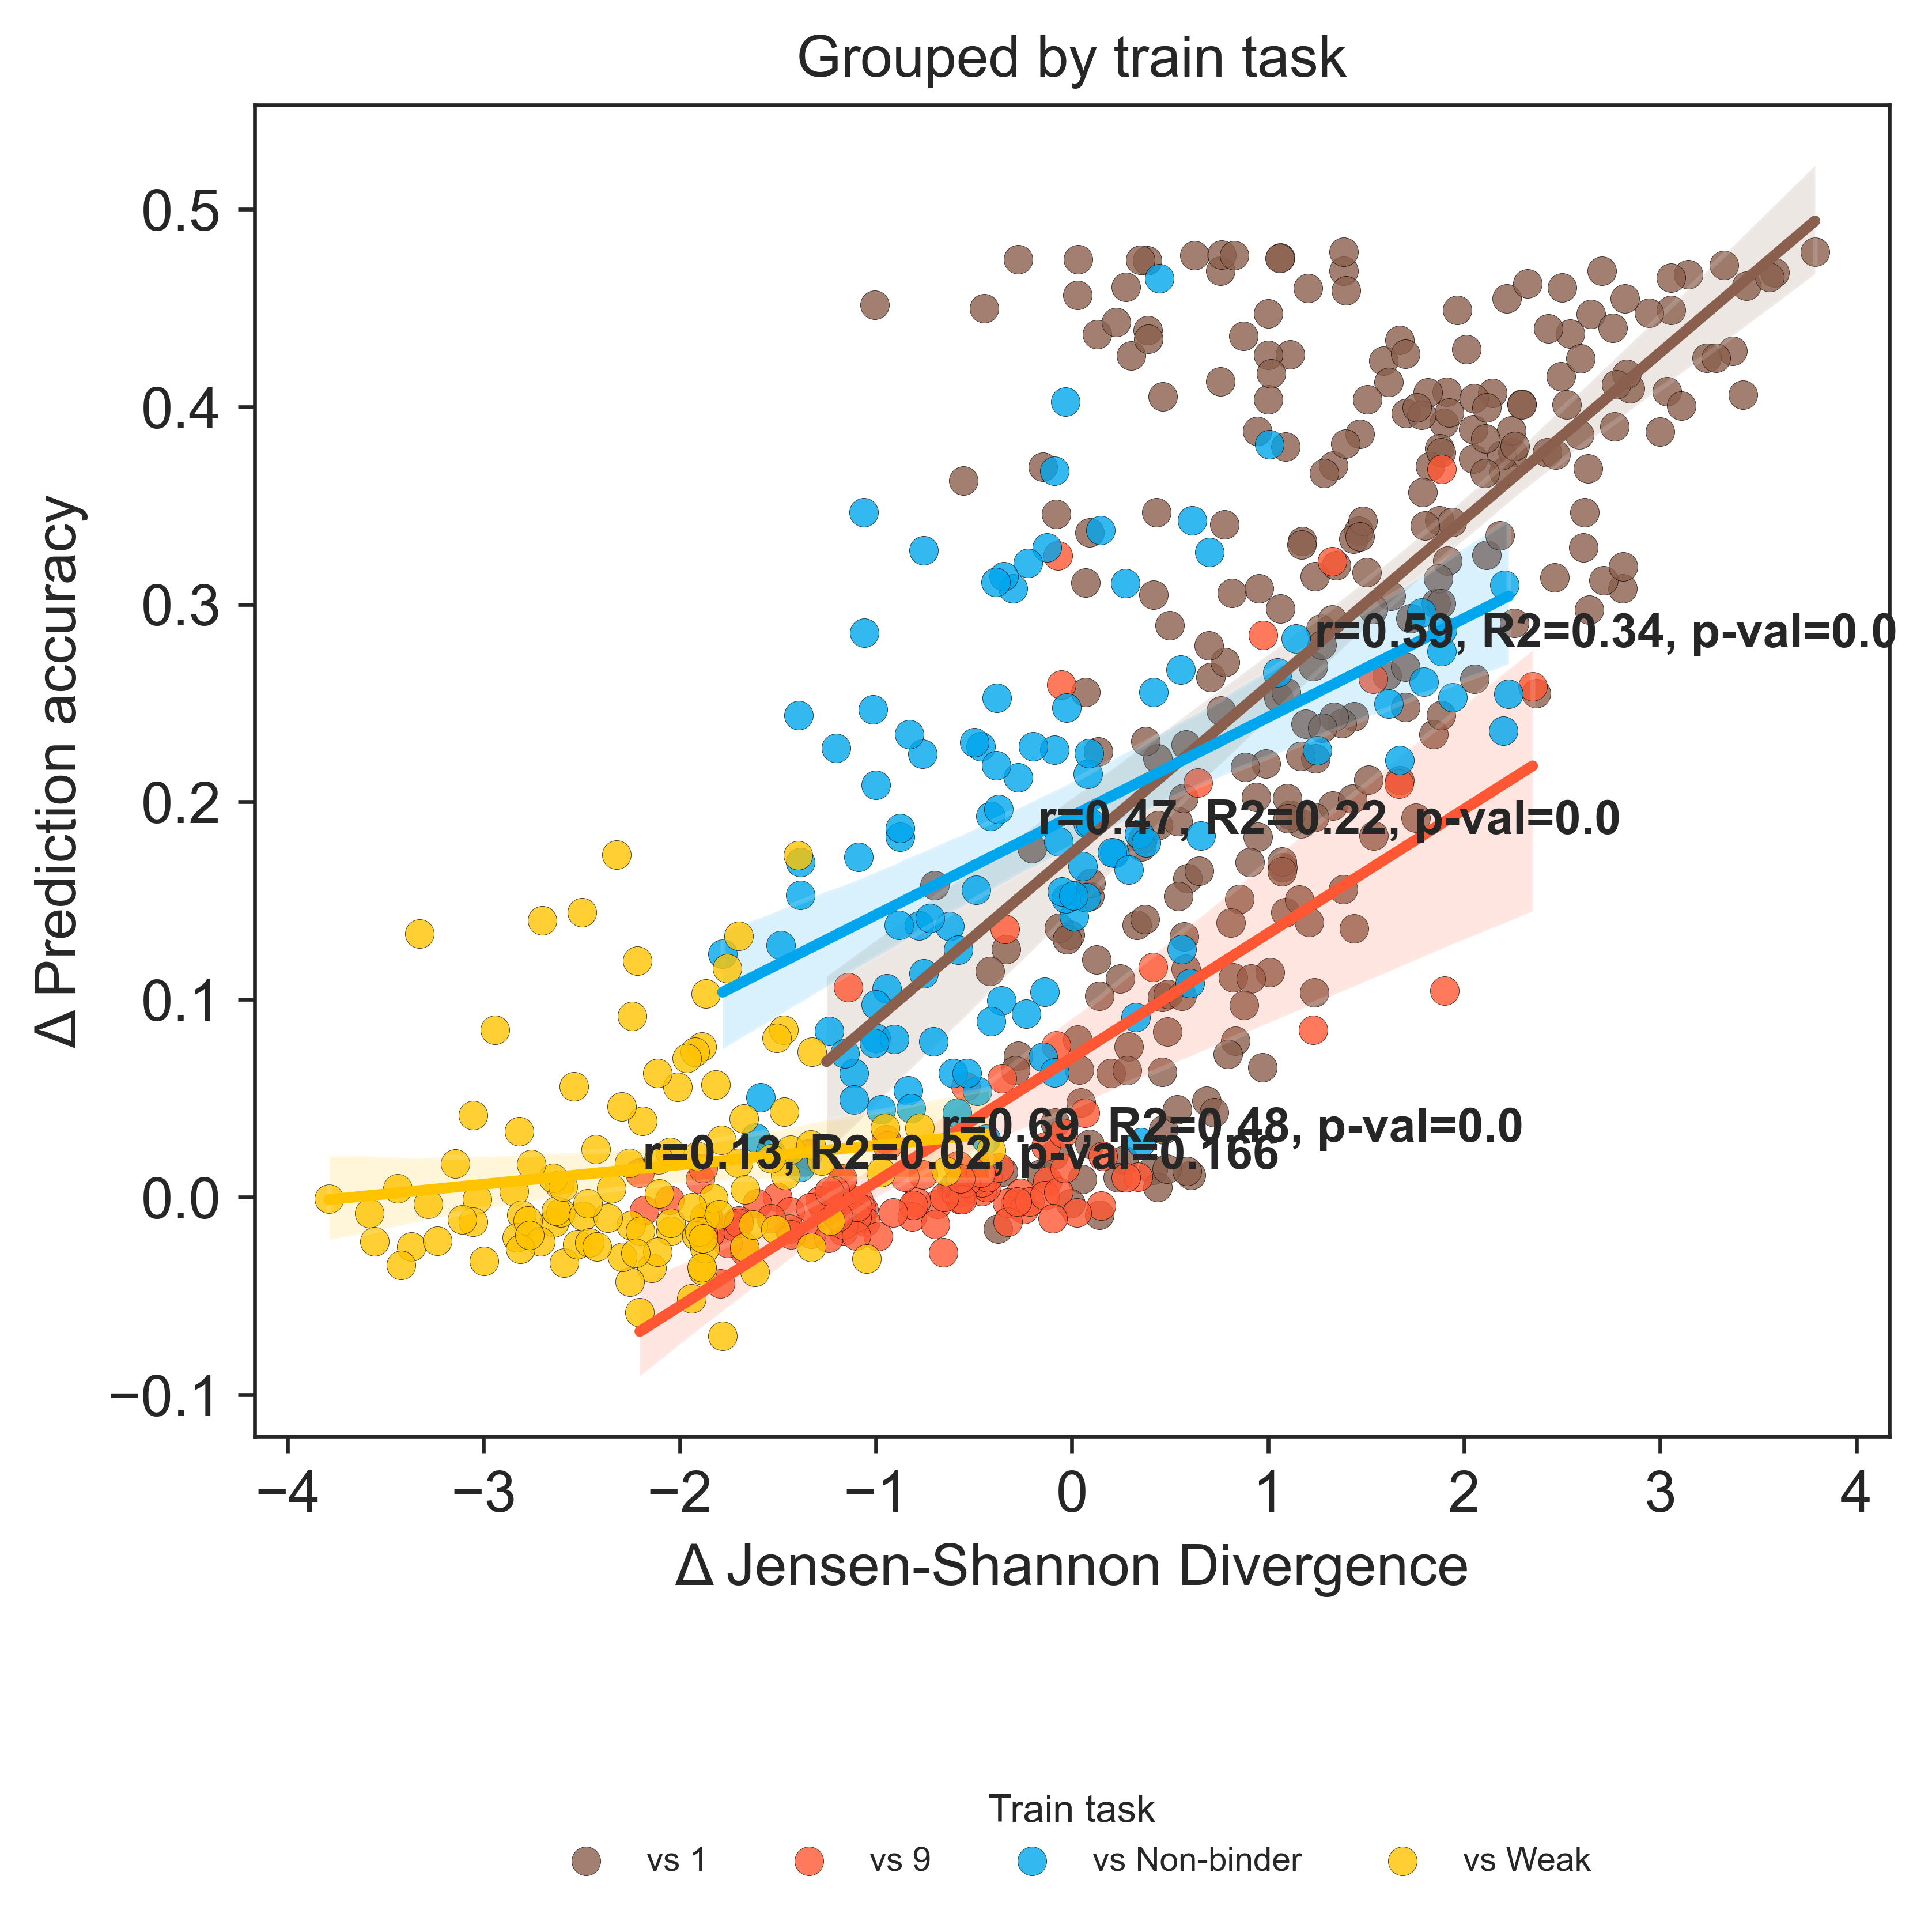

In [34]:
#matters how I calculate delta

cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}
marker_styles = { 'vs 9' : 'o',
         'vs Non-binder':'^',
         'vs Weak':'X',
         'vs 1': '8'}

sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(5*1.22, 5), dpi=600)

# Line plot in seaborn with R2 regression
for task, df_g in perf_open_df_means.groupby("train_task"):
    sns.regplot(
        y="delta_acc",
        x="delta_jsd",
        data=df_g,
        scatter=True,
        ax=ax,
        label=task,
        color=cmap[task],
        scatter_kws={'edgecolor': 'black', 'linewidth': 0.1} 

    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["delta_jsd"], df_g["delta_acc"])
    # Add text with r and R2 at centroid
    x = df_g["delta_jsd"].mean()
    y = df_g["delta_acc"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}, p-val={pval.round(3)}", fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Δ Jensen-Shannon Divergence", fontsize=FONT_SIZE)
ax.set_ylabel("Δ Prediction accuracy", fontsize=FONT_SIZE)
#yticks = np.arange(0.85, 1.0, 0.05)
#ax.set_yticks(yticks)

# Title
# ax.set_title("Relationship beteen SN10 accuracy and Jensen-Shannon Divergence (JSD)", fontsize=FONT_SIZE)


# put legend to the bottom
ax.legend(bbox_to_anchor=(0.5, -0.3), loc="center", borderaxespad=0.0, fontsize=7, title="Train task", title_fontsize=8, ncol=10, frameon=False)
#remove legend
#ax.get_legend().remove()
ax.set_title('Grouped by train task')

fig.show()
#fig.savefig('./figures/delta_jsd_vs_delta_acc_sq.svg')

### Supfig 3b 

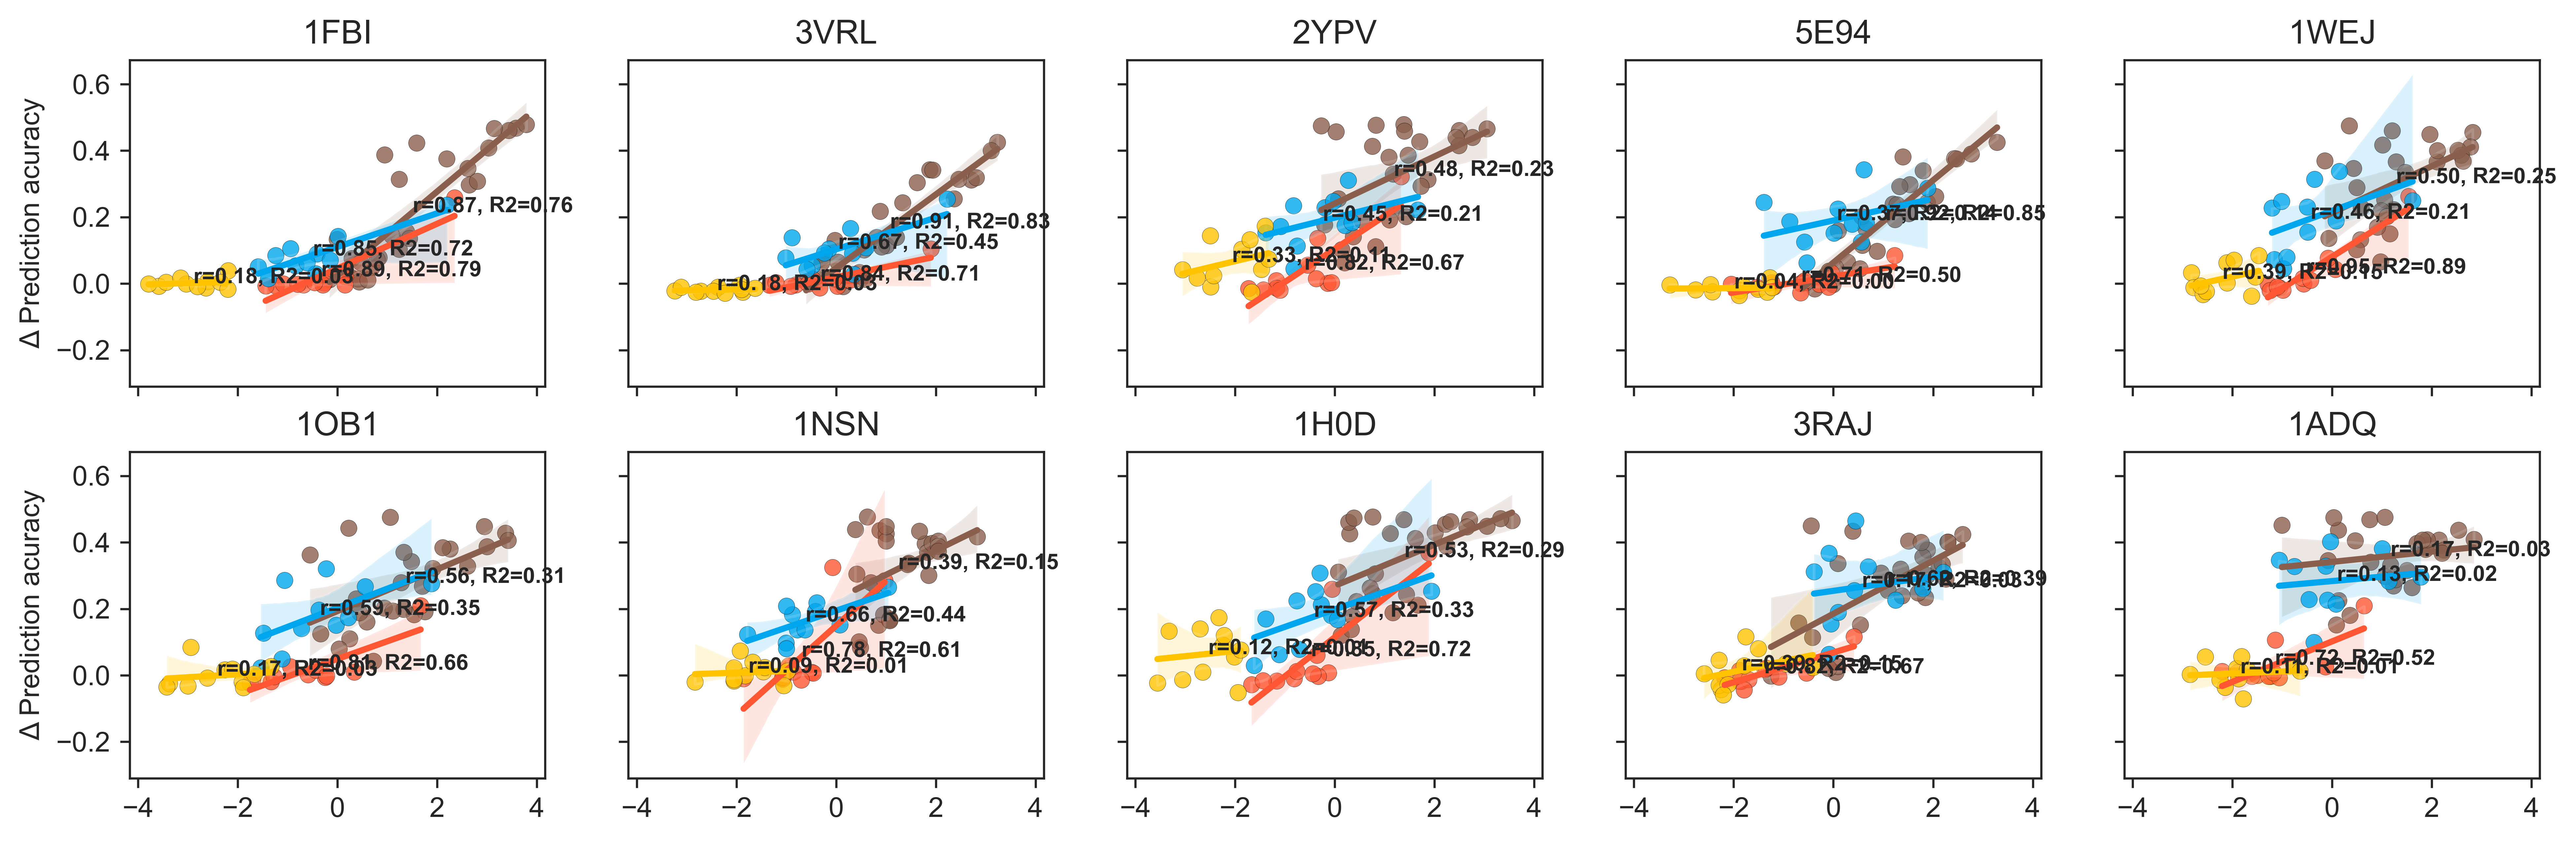

In [133]:
#open performance
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')

fig, ax = plt.subplots(2,5,figsize= (5 * 3.14, 1.5 * 3.14), sharey=True, sharex=True, dpi=600)
# set font size
for i, ag in enumerate(ag_order):
    r = i //5
    c = i % 5
    df = perf_open_df_means[perf_open_df_means['train_ag'] == ag]
    ax_=ax[r,c]

# Line plot in seaborn with R2 regression
    for task, df_g in df.groupby("train_task"):
        sns.regplot(
            x="delta_jsd",
            y="delta_acc",
            data=df_g,
            scatter=True,
            ax=ax_,
            color=cmap[task],
            scatter_kws={'edgecolor': 'black', 'linewidth': 0.1}
        )

        # Compute Pearson correlation
        r, pval = pearsonr(df_g["delta_jsd"], df_g["delta_acc"])
        # Add text with r and R2 at centroid
        x = df_g["delta_jsd"].mean()
        y = df_g["delta_acc"].mean()
        r, pval = pearsonr(df_g["delta_jsd"], df_g["delta_acc"])
        ax_.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=8, fontweight="bold")

        ax_.set_title(ag, fontsize=12)
        if c!=0:
            ax_.set_ylabel('')
        else:
            ax_.set_ylabel('Δ Prediction acuracy')
        #remove xlabel
        ax_.set_xlabel('')

#save
#fig.savefig('./figures/delta_jsd_vs_delta_acc_by_ag.svg')




### Subplot 3C

In [143]:
base_p = Path(config.DATA_BASE_PATH) / "Frozen_MiniAbsolut_ML"
df_lin = pd.read_csv(base_p / "df_task_data_linear.tsv", sep="\t")
df_nlin = pd.read_csv(base_p / "df_task_data.tsv", sep='\t')

In [166]:
df_nlin = df_nlin.groupby(by=["seed_id", "split_id", "task_type", "ag_pos", "ag_neg"])["acc_closed"].mean().reset_index()
df_nlin["model_type"] = "SN10"
df_nlin.to_csv(base_p / "df_task_data_processed.tsv", sep='\t', index=False)
df_lin = df_lin.groupby(by=["seed_id", "split_id", "task_type", "ag_pos", "ag_neg"])["acc_closed"].mean().reset_index()
df_lin["model_type"] = "Linear"

df_lin['task_type'] = df_lin['task_type'].apply(lambda x: folder_2_task[x])
df_nlin['task_type'] = df_nlin['task_type'].apply(lambda x: folder_2_task[x])

df = pd.concat(
    [df_lin,
    df_nlin]
)
df.shape

(986, 7)

Text(0, 0.5, 'Prdeiction accuracy')

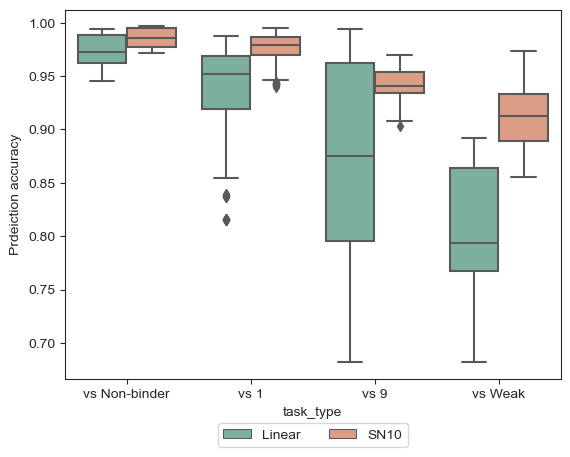

In [181]:
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots()
sns.boxplot(data=df, x="task_type", y='acc_closed', hue='model_type', order=task_clean_order, ax=ax, palette=["#73B7A2", "#EA9776"])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
ax.set_ylabel('Prdeiction accuracy')

### Supplot 3e

In [177]:
perf_df_lin = pd.read_csv(config.DATA_BASE_PATH/"openset_performance_logistic.tsv", sep='\t')
perf_df_lin[['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id']] = perf_df_lin.task_1.str.split('__', expand=True)
perf_df_lin[['test_task', 'test_ag', 'test_neg', 'test_seed_id', 'test_split_id']] = perf_df_lin.task_2.str.split('__', expand=True)
perf_df_lin.drop(['task_1', 'task_2'], inplace=True, axis=1)
perf_df_lin['train_task'] = perf_df_lin['train_task'].apply(lambda x: task_rename[x])
perf_df_lin['test_task'] = perf_df_lin['test_task'].apply(lambda x: task_rename[x])

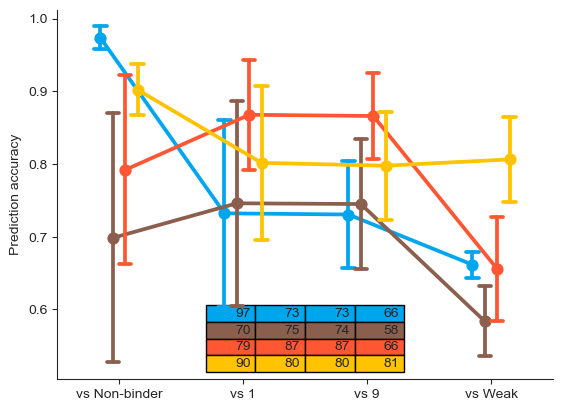

In [190]:
fig, ax = plt.subplots()
sns.set_style("white")
sns.set_style('ticks')
task_order_3 = ['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak']
sns.pointplot(
    perf_df_lin,
    y="acc",
    x="test_task",
    errorbar="sd",
    order=task_clean_order,
    hue="train_task",
    hue_order = task_clean_order,
    palette= cmap,
    # Spread out the points a bit in horizontal
    dodge=0.3,
    ax=ax,
    capsize=0.1,
    estimator='mean'
)

# Add legend horizontally on top of plot area, outside plot area
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    # title_fontsize=8,
)

ax.set_xlabel(None)
ax.set_ylabel("Prediction accuracy")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend().set_visible(False)

#table
table_values = (perf_df_lin.groupby(["train_task", "test_task"])["acc"].mean()\
    .reset_index().pivot(index="train_task", columns="test_task", values="acc")
    .loc[task_clean_order, task_clean_order]\
    .values * 100).round().astype('int')
    #table_values = np.where(table_values == 100, "", table_values)
ax.table(
    cellText=table_values,
    loc='lower center',
    colWidths=[0.1]*4,
    cellColours=np.array([['#00A6ED', '#8B5F4D', '#FF5733', '#FFC300'] for _ in range(4)]).transpose(),
    )
